In [1]:
import re
import numpy as np
import pandas as pd
from keras.datasets import imdb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy.stats as stats

class DataPreprocessor:
    """A class for preprocessing data."""

    def __init__(self):
        self.cleaned_data = None
        self.train_data = None
        self.test_data = None

    def clean_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """Cleans the text data in a DataFrame by removing URLs and special characters, and returns a copy of the cleaned DataFrame."""
        self.cleaned_data = data.copy()
        self.cleaned_data['text'] = self.cleaned_data['text'].apply(self.clean_text)
        self.cleaned_data['target'] = 0  # Add a dummy target column
        return self.cleaned_data
    
    def clean_text(self, text: str) -> str:
        """Cleans the text by removing URLs and special characters, converting it to lowercase, and removing extra whitespaces."""
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def split_data(self, data: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> tuple:
        """Splits the DataFrame into training and testing sets, and returns the sets."""
        self.train_data, self.test_data = train_test_split(data, test_size=test_size, random_state=random_state)
        return self.train_data, self.test_data


class FeatureExtractor:
    """A class for extracting features from text data."""

    def __init__(self, ngram_range: tuple = (1, 1)):
        self.fitted_vectorizer = None
        self.vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        self.features = None
        
    def fit_transform(self, data: pd.DataFrame) -> tuple:
        """Fits the TfidfVectorizer to the text data, transforms it into a feature matrix, and returns the features and target values."""
        text_data = data['text']
        self.fitted_vectorizer = self.vectorizer.fit(text_data)
        self.features = self.fitted_vectorizer.transform(text_data)
        return self.features, data['target']
     
    def transform(self, data: pd.DataFrame) -> tuple:
        """Transforms the text data into a feature matrix using the fitted TfidfVectorizer, and returns the features and target values."""
        if self.fitted_vectorizer is None:
            raise RuntimeError("The FeatureExtractor has not been fitted yet. Use fit_transform() before transform().")
        text_data = data['text']
        self.features = self.fitted_vectorizer.transform(text_data)
        return self.features, data['target']

def load_imdb_dataset():
    """Load Training and Testing data from Keras"""
    (train_data_raw, y_train_raw), (test_data_raw, y_test_raw) = imdb.load_data()
    word_index = imdb.get_word_index()
    index_word = {v: k for k, v in word_index.items()}
    train_data_text = [' '.join([index_word.get(i - 3, '?') for i in t]) for t in train_data_raw]
    test_data_text = [' '.join([index_word.get(i - 3, '?') for i in t]) for t in test_data_raw]
    train_data = pd.DataFrame({'text': train_data_text, 'target': y_train_raw})
    test_data = pd.DataFrame({'text': test_data_text, 'target': y_test_raw})
    return train_data, test_data

def preprocess_dataset(train_data, test_data):
    """Preprocesses data and returns cleaned dataset"""
    preprocessor = DataPreprocessor()
    clean_train_data = preprocessor.clean_data(train_data)
    clean_test_data = preprocessor.clean_data(test_data)
    feature_extractor = FeatureExtractor(ngram_range=(1, 2))
    X_train, _ = feature_extractor.fit_transform(clean_train_data)
    y_train = train_data['target']
    X_test, _ = feature_extractor.transform(clean_test_data)
    y_test = test_data['target']
    X_train_smaller, X_val, y_train_smaller, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test, X_train_smaller, X_val, y_train_smaller, y_val, feature_extractor

def rename_columns(df, column_names):
    """Renames Columns of a pandas dataframe"""
    df.rename(columns=column_names, inplace=True, errors='raise')
    return df


def train_and_evaluate_models(X_train, y_train, X_test, y_test, X_train_smaller, X_val, y_train_smaller, y_val):
    """Trains and evaluates the performance of different models on a given dataset"""
    models = [
        ('Logistic Regression', LogisticRegression()),
        ('SVM', LinearSVC()),
        ('Naive Bayes', MultinomialNB())
    ]

    best_model = None
    best_model_name = ''
    best_score = 0

    for model_name, model in models:
        model.fit(X_train_smaller, y_train_smaller)
        val_score = model.score(X_val, y_val)
        print(f"{model_name} validation accuracy: {val_score:.4f}")
        #update best model
        if val_score > best_score:
            best_score = val_score
            best_model = model
            best_model_name = model_name

    best_model.fit(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    print(f"Best model: {best_model_name}")
    print(f"Test accuracy: {test_score:.4f}")
    return best_model

def extract_tweets(file_paths, columns):
    """Extracts tweets from one or more csv files"""
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, usecols=columns)
        df = df[df['Unnamed: 3'].notna()]
        df = df[df['Unnamed: 2'].notna()]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

def preprocess_tweets(tweets, preprocessor):
    """Preprocesses tweets"""
    textdata = pd.DataFrame(tweets, columns=['text'])
    clean_df = preprocessor.clean_data(textdata)
    return clean_df

def predict_sentiment(X, model):
    """Classifies text bases upon exsiting model"""
    sentiment_labels = model.predict(X)
    return sentiment_labels

def retweet_averages(accounts : list, data : pd.DataFrame) -> dict:
    """Calculate Mean and Standard Deviation of Each account"""
    distributions = {}
    for account in accounts:
        df_acc = df[df['name'] == account]
        df_acc = np.array(df_acc['retweets'])
        df_acc = np.sort(df_acc)
        #get rid of non-integer values
        df_acc = df_acc[:-5].astype(int)
        mean = np.mean(df_acc)
        std = np.std(df_acc)
        distributions[account] = (mean, std)
    return distributions
def generate_core_perhipery_model(perhipery_nodes : int, core_node_fractions : list) -> nx.Graph:
    """Function that generates graph for SIS model. Assigns extra weight to core nodes that have smaller reach (i.e. smaller means and standard deviations)"""
    #Generate perhipery nodes
    model = [np.random.randint(2,5) * 2 for x in range(perhipery_nodes)]
    for fraction in core_node_fractions:
        #give extra weight to every node thats not elon musk
        if fraction < np.mean(core_node_fractions):
            model.append(int(perhipery_nodes * fraction) * 4)
        else:
            model.append(int(perhipery_nodes * fraction) * 2)
    #initialize graph
    g = nx.configuration_model(model, create_using=nx.Graph, seed=13)
    g.remove_edges_from(nx.selfloop_edges(g))
    return g

2023-04-26 13:58:17.761868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 13:58:18.226153: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 13:58:18.278933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 13:58:18.278974: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
#Run Model using functions listed above
train_data, test_data = load_imdb_dataset()
X_train, y_train, X_test, y_test, X_train_smaller, X_val, y_train_smaller, y_val, fitted_feature_extractor = preprocess_dataset(train_data, test_data)
best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test, X_train_smaller, X_val, y_train_smaller, y_val) 

Logistic Regression validation accuracy: 0.8846
SVM validation accuracy: 0.9072
Naive Bayes validation accuracy: 0.8838
Best model: SVM
Test accuracy: 0.9032


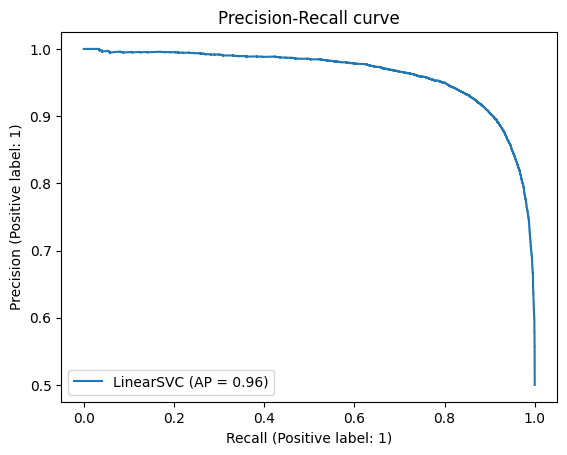

In [3]:
from sklearn.metrics import PrecisionRecallDisplay
#display metrics for model
display = PrecisionRecallDisplay.from_estimator(
    best_model, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("Precision-Recall curve")

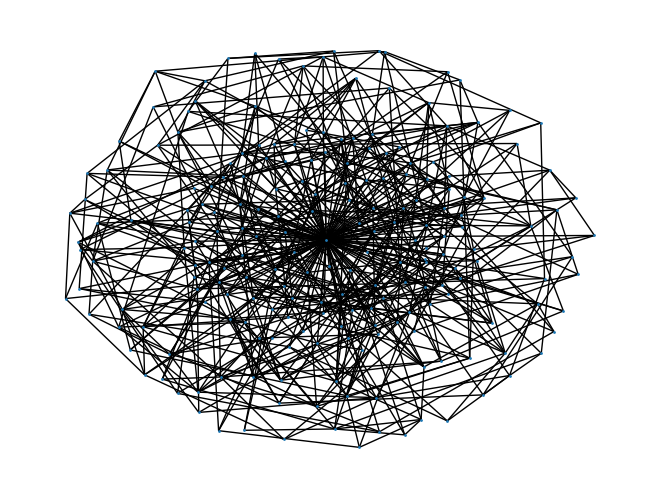

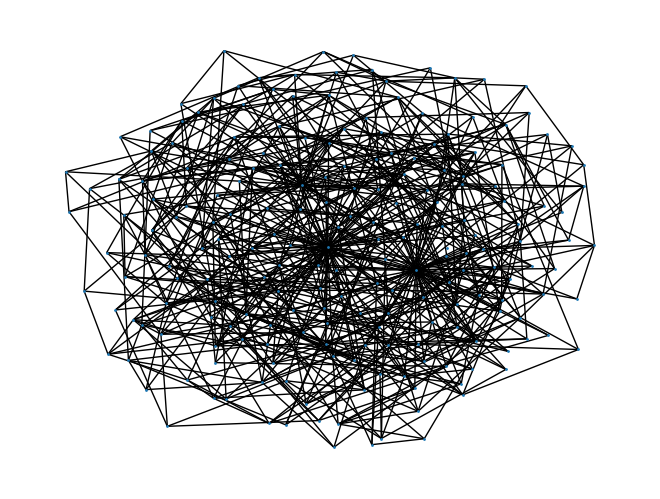

In [4]:
#load in tweets and preprocess the data
file_paths = ["TWITTERDATA/yahoofinance_tweets.csv", "TWITTERDATA/jimcramer_tweets.csv",
              "TWITTERDATA/peterschiff_tweets.csv", "TWITTERDATA/elonmusk_tweets.csv",
              "TWITTERDATA/cathiedwood_tweets.csv", "TWITTERDATA/businessweek_tweets.csv"]
columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 7','Unnamed: 8']
df = extract_tweets(file_paths, columns)
df.drop(df.index[0])
column_names = {'Unnamed: 2': 'name', 'Unnamed: 3': 'text', 'Unnamed: 7' : 'retweets', 'Unnamed: 8' : 'favorites'}
rename_columns(df, column_names)
df['target'] = 0

# Group tweets by account and compute sentiment labels
preprocessor = DataPreprocessor()
clean_df = preprocess_tweets(df, preprocessor)
X_df, _ = fitted_feature_extractor.transform(clean_df)
sentiment_labels = predict_sentiment(X_df, best_model)

#clean up Tweets dataframe by removing non numeric values
df_with_sentiments = df.copy()
df_with_sentiments['target'] = sentiment_labels
df_with_sentiments.to_csv("tweets_with_sentiments.csv", index=False)
means = pd.DataFrame(np.mean(pd.to_numeric(i[1]['retweets'], errors='coerce')) for i in list(df.groupby('name')))
means = np.array(means)
means = means[~np.isnan(means)]


#Core Perhipery Model with Elon Musk
core_node_fractions = [x / (np.sum(means) * 2) for x in means]   
g = generate_core_perhipery_model(200, core_node_fractions)
l = nx.kamada_kawai_layout(g)
nx.draw(g, l, node_size = 1)
plt.show()


#Core Perhipery Model without Elon Musk
means_no_elon = means
means_no_elon[2] = 0.01
core_node_fractions_no_elon = [x / (np.sum(means_no_elon) * 2) for x in means_no_elon]
g = generate_core_perhipery_model(200, core_node_fractions_no_elon)
l = nx.kamada_kawai_layout(g)
nx.draw(g, l, node_size = 1)
plt.show()


In [5]:
def compute_mean_and_std(sentiment_dataframes, sentiment):
    names = list(sentiment_dataframes[sentiment].keys())
    mean_tweets = []
    std_tweets = []
    for name in names:
        # Extract the retweets column as a list of strings
        retweets = sentiment_dataframes[sentiment][name]['retweets']
        # Convert the strings to integers and remove any non-integer values
        retweets_int = [int(r) for r in retweets if r.isdigit()]
        # Compute the mean of the resulting list of integers
        mean_retweets = np.mean(retweets_int)
        # Append the mean to the list of mean retweets
        mean_tweets.append(mean_retweets)
        # Compute the standard deviation of the resulting list of integers
        std_retweets = np.std(retweets_int)
        # Append the standard deviation to the list of standard deviations
        std_tweets.append(std_retweets)
    mean_tweets = [x for x in mean_tweets if str(x) != 'nan']
    std_tweets = [x for x in std_tweets if str(x) != 'nan']
    return mean_tweets, std_tweets

def compare_tweet_distribution(sentiment_dataframes, name):
    #perform t tests on dataframe
    pos = sentiment_dataframes[0][name]['retweets'].astype(int)
    neg = sentiment_dataframes[1][name]['retweets'].astype(int)
    print(f'{name} tweet distribution comparison with unequal variance')
    print(f'P value : {list(stats.ttest_ind(pos, neg, equal_var=False))[1]}')
    pos = sentiment_dataframes[0][name]['retweets'].astype(int)
    neg = sentiment_dataframes[1][name]['retweets'].astype(int)
    print(f'{name} tweet distribution comparison with equal variance')
    print(f'P value : {list(stats.ttest_ind(pos, neg, equal_var=True))[1]}')

#group tweets into user and sentiment categories
sentiment_groups = df_with_sentiments.groupby(['name', 'target'])
sentiment_dataframes = {}
for (name, sentiment), group in sentiment_groups:
    if sentiment not in sentiment_dataframes:
        sentiment_dataframes[sentiment] = {}
    sentiment_dataframes[sentiment][name] = group.reset_index(drop=True)

#zipped tuple of account, mean retweets for each sentiment, and std of retweets for each sentiment
mean_negative_tweets, std_negative_tweets = compute_mean_and_std(sentiment_dataframes, 0)
print(list(zip(list(sentiment_dataframes[0].keys()), mean_negative_tweets, std_negative_tweets)))

mean_positive_tweets, std_positive_tweets = compute_mean_and_std(sentiment_dataframes, 1)
print(list(zip(list(sentiment_dataframes[0].keys()), mean_positive_tweets, std_positive_tweets)))

#run t tests on each account
for name in sentiment_dataframes[0].keys():
    compare_tweet_distribution(sentiment_dataframes, name)


[('Businessweek', 6.109339407744875, 11.774770498508548), ('Cathie Wood', 154.9874389392882, 991.8602419439587), ('Elon Musk', 5691.014195583596, 15190.467475159838), ('Jim Cramer', 61.45367192862045, 1093.3854822124765), ('Peter Schiff', 88.6036615536863, 233.81047604843818), ('Yahoo Finance', 4.516009852216749, 5.71617184240665)]
[('Businessweek', 9.734764542936288, 33.35855547771094), ('Cathie Wood', 279.7622020431328, 4020.774496447686), ('Elon Musk', 6539.8737412858245, 14838.507800003566), ('Jim Cramer', 348.1921523369879, 10529.01780605353), ('Peter Schiff', 123.03318777292577, 1074.4047535470156), ('Yahoo Finance', 4.663265306122449, 7.343616383136709)]
Businessweek tweet distribution comparison with unequal variance
P value : 8.756995947693841e-05
Businessweek tweet distribution comparison with equal variance
P value : 2.2709921811203157e-05
Cathie Wood tweet distribution comparison with unequal variance
P value : 0.20922300549011055
Cathie Wood tweet distribution comparison w

/home/kali/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kali/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kali/.local/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kali/.local/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kali/.local/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


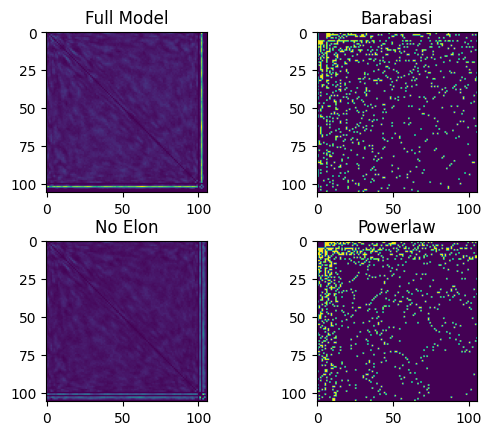

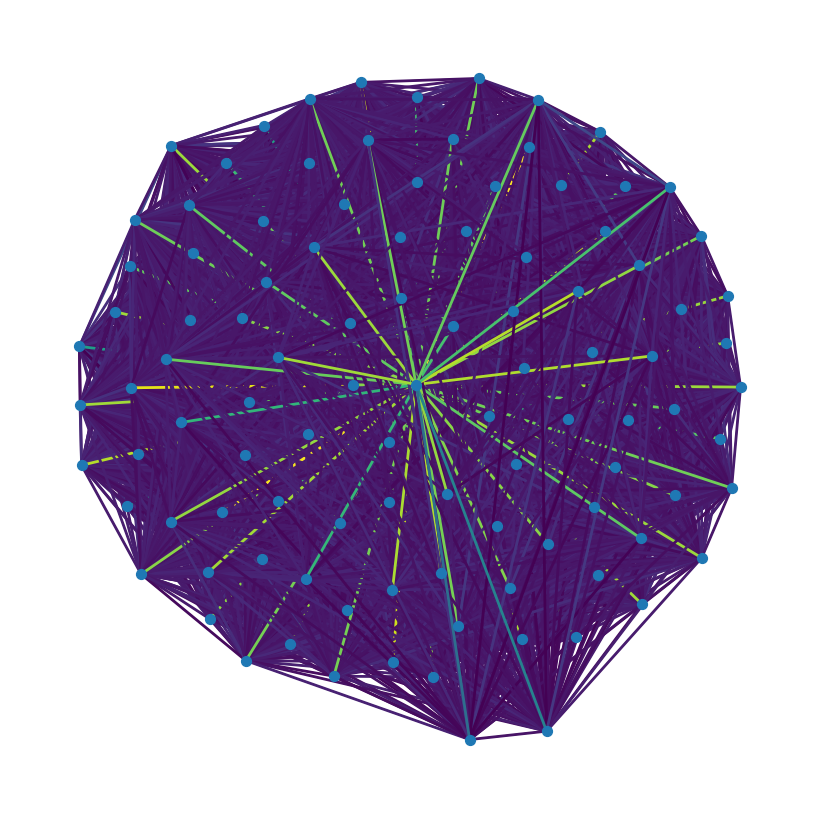

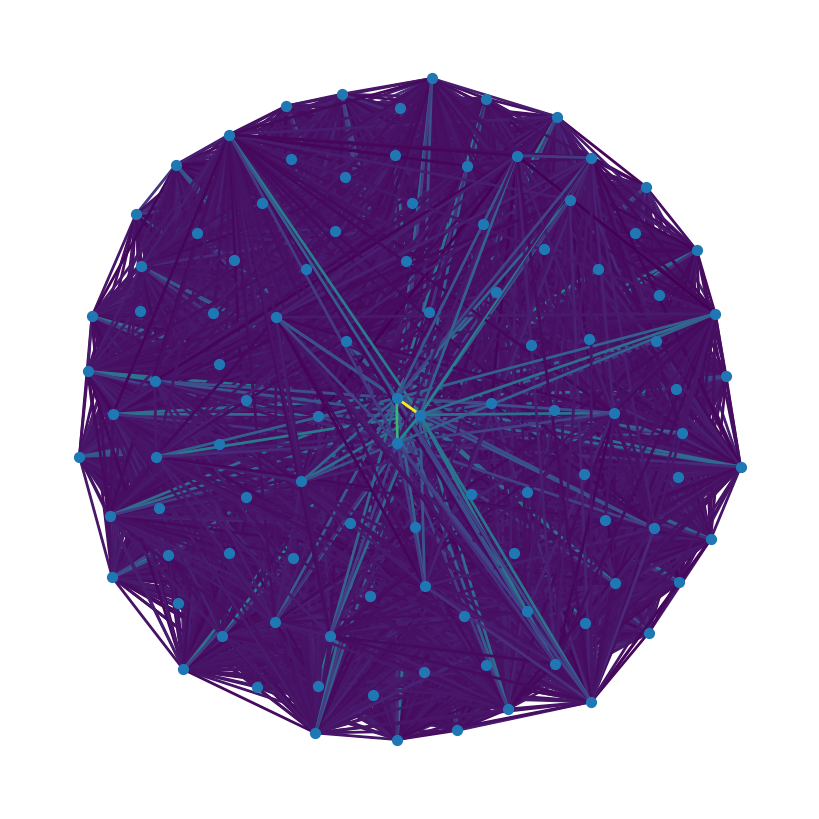

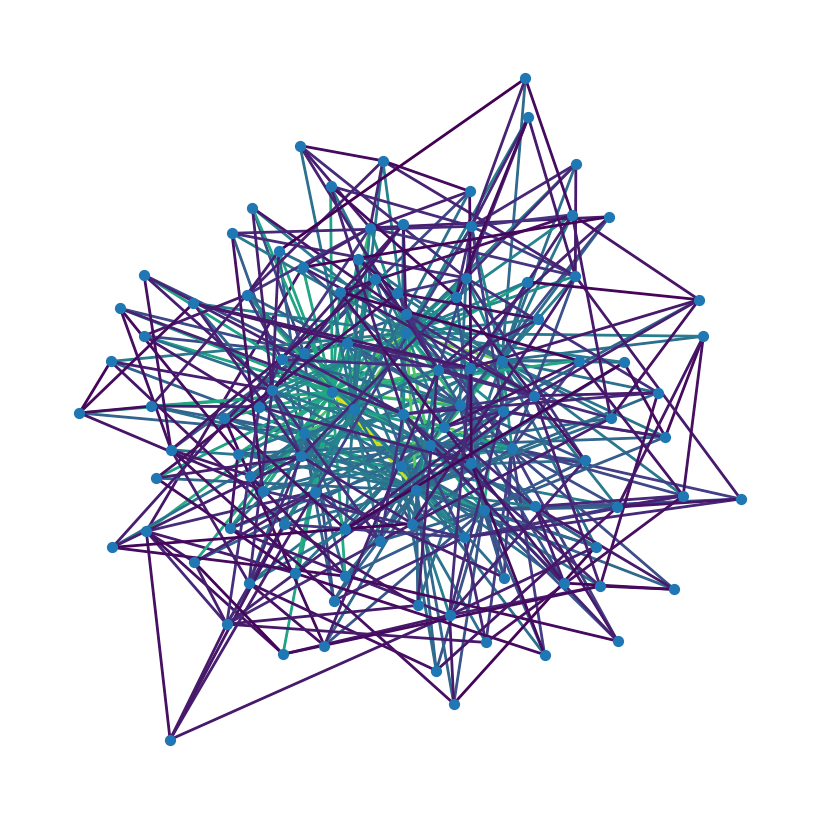

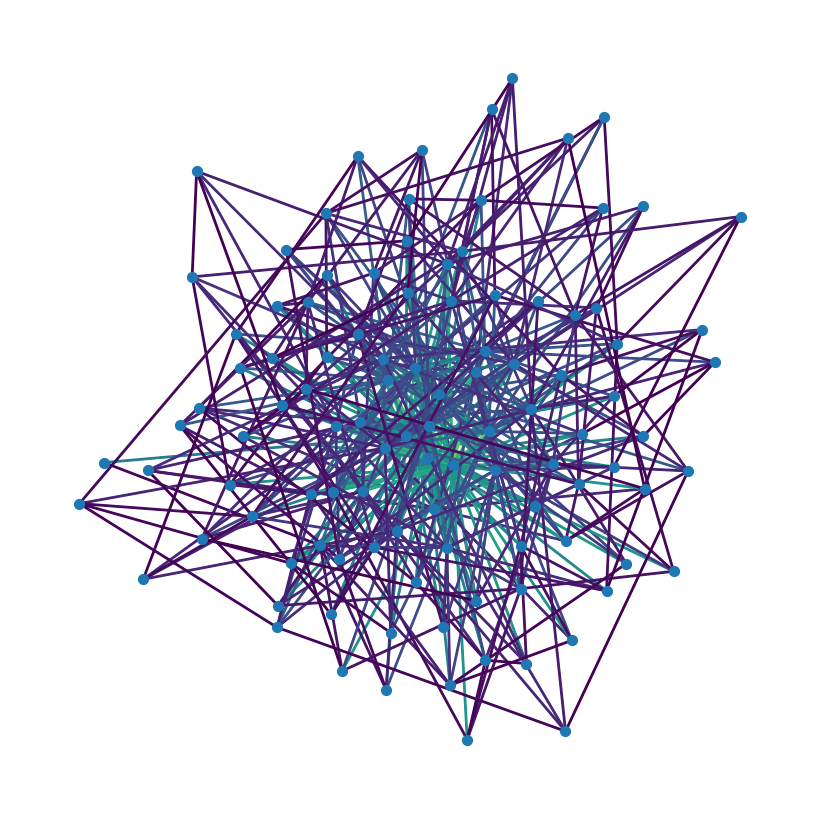

In [6]:
#number of samples
samples = 1000
perhipery_nodes = 100
#initialize average graphs
avg_g = np.zeros((len(means) + perhipery_nodes, len(means) + perhipery_nodes))
avg_g_ne = np.zeros((len(means_no_elon) + perhipery_nodes, len(means_no_elon) + perhipery_nodes))
#Random Barabasi Albert distribution with same number of nodes : Null model 1
avg_null_b = np.zeros((len(means) + perhipery_nodes, len(means) + perhipery_nodes))
#Random Power Law distribution with same number of nodes : Null model 2
avg_null_p = np.zeros((len(means) + perhipery_nodes, len(means) + perhipery_nodes))

#construct average graphs
for i in range(samples):
    avg_g += nx.adjacency_matrix(generate_core_perhipery_model(perhipery_nodes, core_node_fractions))
    avg_g_ne += nx.adjacency_matrix(generate_core_perhipery_model(perhipery_nodes, core_node_fractions_no_elon))
    avg_null_b += nx.adjacency_matrix(nx.barabasi_albert_graph(perhipery_nodes + 6, 5, seed=17))
    avg_null_p += nx.adjacency_matrix(nx.powerlaw_cluster_graph(perhipery_nodes + 6, 5, .6 , seed=17))                                     
avg_g /= samples
avg_g_ne /= samples
avg_null_p /= samples 
avg_null_b /= samples                                      
# Plot average adjacency matrix
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(avg_g)
axs[0,0].set_title('Full Model')
axs[1,0].imshow(avg_g_ne)
axs[1,0].set_title('No Elon')
axs[0,1].imshow(avg_null_b)
axs[0,1].set_title('Barabasi')
axs[1,1].imshow(avg_null_p)
axs[1,1].set_title('Powerlaw')
matplotlib.pyplot.subplots_adjust(hspace=.3)
plt.show()

#remove nodes that are disconnected from fully connected component
avg_g = nx.from_numpy_array(avg_g)
avg_g.remove_nodes_from(list(nx.isolates(avg_g)))
avg_g_ne = nx.from_numpy_array(avg_g_ne)
avg_g_ne.remove_nodes_from(list(nx.isolates(avg_g_ne)))
avg_null_p = nx.from_numpy_array(avg_null_p)
avg_null_p.remove_nodes_from(list(nx.isolates(avg_null_p)))
avg_null_b = nx.from_numpy_array(avg_null_b)
avg_null_b.remove_nodes_from(list(nx.isolates(avg_null_b)))


plt.figure(figsize=(8, 8))
pos = nx.spring_layout(avg_g, k=0.2, seed=42)
# Get the edge weights as a list
edge_weights = [d['weight'] for (u, v, d) in avg_g.edges(data=True)]
# Normalize the edge weights
edge_weights_normalized = [w / max(edge_weights) for w in edge_weights]
# Draw the nodes
nx.draw(avg_g, pos, node_size=50)
# Draw the edges with colors based on the edge weights
nx.draw_networkx_edges(avg_g, pos, edge_color=edge_weights_normalized, width=2)
plt.show()

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(avg_g_ne, k=0.2, seed=42)
# Get the edge weights as a list
edge_weights = [d['weight'] for (u, v, d) in avg_g_ne.edges(data=True)]
# Normalize the edge weights
edge_weights_normalized = [w / max(edge_weights) for w in edge_weights]
# Draw the nodes
nx.draw(avg_g_ne, pos, node_size=50)
# Draw the edges with colors based on the edge weights
nx.draw_networkx_edges(avg_g_ne, pos, edge_color=edge_weights_normalized, width=2)
plt.show()

for u, v in avg_null_p.edges():
    avg_null_p.edges[u, v]['weight'] = avg_null_p.degree(u) + avg_null_p.degree(v)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(avg_null_p, k=0.2, seed=42)
# Get the edge weights as a list
edge_weights = [d['weight'] for (u, v, d) in avg_null_p.edges(data=True)]
# Calculate the average node degree
node_degrees = dict(avg_null_p.degree())
avg_node_degree = sum(node_degrees.values()) / len(node_degrees)
# Normalize the edge weights by the average node degree
edge_weights_normalized = [w / avg_node_degree for w in edge_weights]
# Draw the nodes
nx.draw(avg_null_p, pos, node_size=50)
# Draw the edges with colors based on the edge weights
nx.draw_networkx_edges(avg_null_p, pos, edge_color=edge_weights_normalized, width=2)
plt.show()

for u, v in avg_null_b.edges():
    avg_null_b.edges[u, v]['weight'] = avg_null_b.degree(u) + avg_null_b.degree(v)
    
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(avg_null_b, k=0.2, seed=42)
# Get the edge weights as a list
edge_weights = [d['weight'] for (u, v, d) in avg_null_b.edges(data=True)]
# Calculate the average node degree

node_degrees = dict(avg_null_b.degree())
avg_node_degree = sum(node_degrees.values()) / len(node_degrees)
# Normalize the edge weights by the average node degree
edge_weights_normalized = [w / avg_node_degree for w in edge_weights]
# Draw the nodes
nx.draw(avg_null_b, pos, node_size=50)
# Draw the edges with colors based on the edge weights
nx.draw_networkx_edges(avg_null_b, pos, edge_color=edge_weights_normalized, width=2)
plt.show()


In [11]:
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

#initialize number of samples and iterations
samples = 1000
iteration_count = 5
#initialize lists, arrays, and scalars
diffusion_trends_avg_g = []
node_infections_avg_g = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0

for i in range(samples):
    # Initialize the threshold model
    model = ep.ThresholdModel(avg_g)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(105)
    config.add_model_initial_configuration('Infected', infected_nodes)
    
    # Set default configuration for all nodes
    for i in avg_g.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_g.nodes():
        # Set the threshold based on the average weight of its edges
        threshold = sum(avg_g[i][j]['weight'] for j in avg_g.neighbors(i)) / avg_g.degree(i)
        config.add_node_configuration("threshold", i, threshold)

    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    #viz.plot("diffusion_elon.pdf")
    diffusion_trends_avg_g.append(viz)
    node_infections_avg_g += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))

#normalize values
average_node_infections_avg_g = node_infections_avg_g / samples
average_fraction_infected /= samples

print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_g)

'''
The rest of the code in this project is equivalent to the code above this text, with variations in initial starting infected nodes and variations
in average model used.
'''

diffusion_trends_avg_g_ne = []
node_infections_avg_g_ne = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0


for i in range(samples):
    # Initialize the threshold model
    model = ep.ThresholdModel(avg_g_ne)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(102)
    config.add_model_initial_configuration('Infected', infected_nodes)
    
    # Set default configuration for all nodes
    for i in avg_g_ne.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_g_ne.nodes():
        # Set the threshold based on the average weight of its edges
        threshold = sum(avg_g_ne[i][j]['weight'] for j in avg_g_ne.neighbors(i)) / avg_g_ne.degree(i)
        config.add_node_configuration("threshold", i, threshold)
    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    diffusion_trends_avg_g_ne.append(viz)
    node_infections_avg_g_ne += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))

average_node_infections_avg_g_ne = node_infections_avg_g_ne / samples
average_fraction_infected /= samples

print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_g_ne)



diffusion_trends_avg_g_ne = []
node_infections_avg_g_ne = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0


for i in range(samples):
    # Initialize the threshold model
    model = ep.ThresholdModel(avg_g_ne)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(103)
    config.add_model_initial_configuration('Infected', infected_nodes)
    
    # Set default configuration for all nodes
    for i in avg_g_ne.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_g_ne.nodes():
        # Set the threshold based on the average weight of its edges
        threshold = sum(avg_g_ne[i][j]['weight'] for j in avg_g_ne.neighbors(i)) / avg_g_ne.degree(i)
        config.add_node_configuration("threshold", i, threshold)
    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    diffusion_trends_avg_g_ne.append(viz)
    node_infections_avg_g_ne += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))

average_node_infections_avg_g_ne = node_infections_avg_g_ne / samples
average_fraction_infected /= samples

print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_g_ne)

diffusion_trends_avg_g_ne = []
node_infections_avg_g_ne = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0


for i in range(samples):
    # Initialize the threshold model
    model = ep.ThresholdModel(avg_g_ne)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(104)
    config.add_model_initial_configuration('Infected', infected_nodes)
    
    # Set default configuration for all nodes
    for i in avg_g_ne.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_g_ne.nodes():
        # Set the threshold based on the average weight of its edges
        threshold = sum(avg_g_ne[i][j]['weight'] for j in avg_g_ne.neighbors(i)) / avg_g_ne.degree(i)
        config.add_node_configuration("threshold", i, threshold)
    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    diffusion_trends_avg_g_ne.append(viz)
    node_infections_avg_g_ne += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))

average_node_infections_avg_g_ne = node_infections_avg_g_ne / samples
average_fraction_infected /= samples

print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_g_ne)

diffusion_trends_avg_g_ne = []
node_infections_avg_g_ne = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0


for i in range(samples):
    # Initialize the threshold model
    model = ep.ThresholdModel(avg_g_ne)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(102)
    infected_nodes.append(104)
    infected_nodes.append(103)
    config.add_model_initial_configuration('Infected', infected_nodes)
    
    # Set default configuration for all nodes
    for i in avg_g_ne.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_g_ne.nodes():
        # Set the threshold based on the average weight of its edges
        threshold = sum(avg_g_ne[i][j]['weight'] for j in avg_g_ne.neighbors(i)) / avg_g_ne.degree(i)
        config.add_node_configuration("threshold", i, threshold)
    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    diffusion_trends_avg_g_ne.append(viz)
    node_infections_avg_g_ne += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))

average_node_infections_avg_g_ne = node_infections_avg_g_ne / samples
average_fraction_infected /= samples

print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_g_ne)



0.55667
[ 0.0000e+00 -3.4938e+01 -2.0034e+01 -6.9100e-01 -4.0000e-03]
0.35284
[  0.    -34.177  -1.107   0.      0.   ]
0.45378999999999997
[  0.    -44.425  -0.954   0.      0.   ]
0.47409
[  0.    -46.413  -0.996   0.      0.   ]
0.56573
[  0.    -55.975  -0.598   0.      0.   ]


In [12]:
iteration_count = 30

diffusion_trends_avg_null_p = []
node_infections_avg_null_p = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0


for i in range(samples):
    model = ep.ThresholdModel(avg_null_p)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(102)
    infected_nodes.append(103)
    infected_nodes.append(104)
    infected_nodes.append(105)
    config.add_model_initial_configuration('Infected', infected_nodes)

    # Set default configuration for all nodes
    for i in avg_null_p.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_null_p.nodes():
        # Set the threshold based on the average weight of its edges
        threshold = sum(avg_null_p[i][j]['weight'] for j in avg_null_p.neighbors(i)) / (avg_null_p.degree(i) * 100)
        config.add_node_configuration("threshold", i, threshold)

    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    diffusion_trends_avg_null_p.append(viz)
    node_infections_avg_null_p += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))
    
average_node_infections_avg_null_p = node_infections_avg_null_p / samples
average_fraction_infected /= samples

print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_null_p)

diffusion_trends_avg_null_b = []
node_infections_avg_null_b = np.zeros((iteration_count, ), dtype=int)
average_fraction_infected = 0


for i in range(samples):
    model = ep.ThresholdModel(avg_null_b)
    config = mc.Configuration()
    infected = np.random.randint(10)
    infected_nodes = [np.random.randint(100) for j in range(infected)]
    infected_nodes.append(102)
    infected_nodes.append(103)
    infected_nodes.append(104)
    infected_nodes.append(105)
    config.add_model_initial_configuration('Infected', infected_nodes)

    # Set default configuration for all nodes
    for i in avg_null_b.nodes():
        config.add_node_configuration("threshold", i, 0.10)
    # Set the node thresholds
    for i in avg_null_b.nodes():
        # Set the threbshold based on the average weight of its edges
        threshold = sum(avg_null_b[i][j]['weight'] for j in avg_null_b.neighbors(i)) / (avg_null_b.degree(i) * 100)
        config.add_node_configuration("threshold", i, threshold)

    model.set_initial_status(config)
    # Set the source node and run the simulation
    iterations = model.iteration_bunch(iteration_count)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    diffusion_trends_avg_null_b.append(viz)
    node_infections_avg_null_b += np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0])
    average_fraction_infected += np.sum(np.array(list(list(list(viz.trends)[0].values())[0]['status_delta'].values())[0]))
    
average_node_infections_avg_null_b = node_infections_avg_null_b / samples
average_fraction_infected /= samples
                                                                                                                
print(str(abs(average_fraction_infected) / 100))
print(average_node_infections_avg_null_b)

0.43018999999999996
[ 0.    -3.877 -3.687 -4.151 -4.447 -5.007 -4.872 -4.029 -3.327 -2.554
 -1.819 -1.39  -1.174 -0.862 -0.672 -0.456 -0.251 -0.139 -0.09  -0.034
 -0.02  -0.05  -0.057 -0.047 -0.007  0.     0.     0.     0.     0.   ]
0.4705
[ 0.000e+00 -5.432e+00 -3.950e+00 -5.101e+00 -6.461e+00 -6.533e+00
 -5.589e+00 -4.152e+00 -3.112e+00 -2.224e+00 -1.523e+00 -1.033e+00
 -6.090e-01 -4.560e-01 -3.680e-01 -2.250e-01 -1.330e-01 -9.900e-02
 -4.800e-02 -2.000e-03  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
